In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('dataset_final.xlsx')


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   TANGGAL  3983 non-null   datetime64[ns]
 1   TN       3983 non-null   float64       
 2   TX       3983 non-null   float64       
 3   TAVG     3983 non-null   float64       
 4   RH_AVG   3983 non-null   float64       
 5   RR       3983 non-null   float64       
 6   SS       3983 non-null   float64       
 7   FF_X     3983 non-null   int64         
 8   DDD_X    3983 non-null   int64         
 9   FF_AVG   3983 non-null   int64         
 10  DDD_CAR  3983 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 342.4 KB


In [51]:
# Feature Engineering 

def create_advanced_features(df):
    """
    Membuat fitur-fitur advanced untuk prediksi curah hujan
    """
    df = df.copy()
    
    print("Creating advanced features...")
    
    df['month'] = df['TANGGAL'].dt.month
    df['day'] = df['TANGGAL'].dt.day
    df['dayofyear'] = df['TANGGAL'].dt.dayofyear
    df['week'] = df['TANGGAL'].dt.isocalendar().week
    df['quarter'] = df['TANGGAL'].dt.quarter
    df['dayofweek'] = df['TANGGAL'].dt.dayofweek
    
    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    # Musim hujan Indonesia
    df['is_rainy_season'] = df['month'].apply(lambda x: 1 if x in [11, 12, 1, 2, 3] else 0)
    
   #Lag features
    for i in range(1, 8):
        df[f'RR_lag{i}'] = df['RR'].shift(i)
    
    for col in ['TAVG', 'RH_AVG', 'FF_AVG', 'SS']:
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_lag2'] = df[col].shift(2)
        df[f'{col}_lag3'] = df[col].shift(3)
    
    # Rolling Statistic
    windows = [3, 7, 14, 30]
    
    for window in windows:
        df[f'RR_mean{window}'] = df['RR'].rolling(window=window).mean()
        df[f'RR_max{window}'] = df['RR'].rolling(window=window).max()
        df[f'RR_min{window}'] = df['RR'].rolling(window=window).min()
        df[f'RR_std{window}'] = df['RR'].rolling(window=window).std()
        df[f'RR_sum{window}'] = df['RR'].rolling(window=window).sum()
        
        df[f'TAVG_mean{window}'] = df['TAVG'].rolling(window=window).mean()
        df[f'TAVG_std{window}'] = df['TAVG'].rolling(window=window).std()
        
        df[f'RH_AVG_mean{window}'] = df['RH_AVG'].rolling(window=window).mean()
        df[f'RH_AVG_std{window}'] = df['RH_AVG'].rolling(window=window).std()
    
    # Trend Features
    df['consecutive_rainy'] = (df['RR'] > 0).groupby((df['RR'] == 0).cumsum()).cumsum()
    df['consecutive_dry'] = (df['RR'] == 0).groupby((df['RR'] > 0).cumsum()).cumsum()
    
    df['rainy_days_7d'] = df['RR'].rolling(window=7).apply(lambda x: (x > 0).sum())
    df['rainy_days_14d'] = df['RR'].rolling(window=14).apply(lambda x: (x > 0).sum())
    df['rainy_days_30d'] = df['RR'].rolling(window=30).apply(lambda x: (x > 0).sum())
    
    df['is_rainy_yesterday'] = (df['RR_lag1'] > 0).astype(int)
    df['is_rainy_2days_ago'] = (df['RR_lag2'] > 0).astype(int)
    
    # Interaction Features
    df['temp_humidity'] = df['TAVG'] * df['RH_AVG']
    df['temp_range'] = df['TX'] - df['TN']
    df['sunshine_humidity'] = df['SS'] * (100 - df['RH_AVG'])
    df['wind_humidity'] = df['FF_AVG'] * df['RH_AVG']
    df['temp_wind'] = df['TAVG'] * df['FF_AVG']
    
    # EXPONENTIAL MOVING AVERAGE
    df['RR_ema3'] = df['RR'].ewm(span=3, adjust=False).mean()
    df['RR_ema7'] = df['RR'].ewm(span=7, adjust=False).mean()
    df['RH_AVG_ema7'] = df['RH_AVG'].ewm(span=7, adjust=False).mean()
    
    # Rate of change 
    df['RR_change'] = df['RR'].diff()
    df['TAVG_change'] = df['TAVG'].diff()
    df['RH_AVG_change'] = df['RH_AVG'].diff()
    
    # Percentile Features
    df['RR_percentile_30d'] = df['RR'].rolling(window=30).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
    )
    
    print(f"Created {len(df.columns)} features total")
    
    return df

In [52]:
#Exclude Date and RR 

exclude_cols = ['TANGGAL', 'RR']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df['RR']

print(f"Total features: {len(feature_cols)}")

# Tahap 1: Split train (70%) dan sisa (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

# Tahap 2: Split sisa (30%) menjadi validation (10%) dan test (20%)
# Rasio val:test = 1:2 → test_size=20/(10+20)=0.6667 dari X_temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, shuffle=False
)

print(f"🔹 Train size: {len(X_train)}")
print(f"🔹 Validation size: {len(X_val)}")
print(f"🔹 Test size: {len(X_test)}")

results = {}

Total features: 9
🔹 Train size: 2788
🔹 Validation size: 398
🔹 Test size: 797


In [53]:
df = create_advanced_features(df)
df_clean = df.dropna().reset_index(drop=True)

print(f"\nData shape after feature engineering: {df_clean.shape}")

Creating advanced features...
Created 96 features total

Data shape after feature engineering: (3954, 96)


In [54]:
print("SEARCHING FOR OPTIMAL THRESHOLDS...")

# Test all threshold combination
rain_thresholds = [0.1, 0.5, 1.0]  # mm
prob_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7] 

best_mae = float('inf')
best_config = {}
results_list = []

for RAIN_THRESHOLD in rain_thresholds:
    print(f"\nTest RAIN_THRESHOLD = {RAIN_THRESHOLD} mm")
    

    df_clean['is_rain'] = (df_clean['RR'] > RAIN_THRESHOLD).astype(int)
    

    exclude_cols = ['TANGGAL', 'RR', 'is_rain']
    feature_cols = [col for col in df_clean.columns if col not in exclude_cols]
    
    X = df_clean[feature_cols]
    y_regression = df_clean['RR']
    y_classification = df_clean['is_rain']
    
    # Split data
    X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
        X, y_regression, y_classification, test_size=0.2, shuffle=False
    )
    
    # ===== TRAIN CLASSIFIER =====
    classifier = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=50,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    )
    
    classifier.fit(X_train, y_cls_train)
    rain_probability = classifier.predict_proba(X_test)[:, 1]
    
    # ===== TRAIN REGRESSOR (hanya pada hari hujan) =====
    rain_mask_train = y_reg_train > RAIN_THRESHOLD
    X_train_rain = X_train[rain_mask_train]
    y_train_rain = y_reg_train[rain_mask_train]
    
    regressor = GradientBoostingRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=7,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=0.8,
        loss='huber',
        alpha=0.9,
        random_state=42
    )
    
    regressor.fit(X_train_rain, y_train_rain)
    
    # ===== TEST BERBAGAI PROBABILITY THRESHOLD =====
    for PROB_THRESHOLD in prob_thresholds:
        # Two-stage prediction
        y_pred_final = np.zeros(len(X_test))
        
        for i in range(len(X_test)):
            if rain_probability[i] > PROB_THRESHOLD:
                rain_amount = regressor.predict(X_test.iloc[[i]])[0]
                y_pred_final[i] = max(0, rain_amount)
            else:
                y_pred_final[i] = 0.0
        
        # Evaluasi
        mae = mean_absolute_error(y_reg_test, y_pred_final)
        rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_final))
        r2 = r2_score(y_reg_test, y_pred_final)
        
        # Simpan hasil
        results_list.append({
            'rain_threshold': RAIN_THRESHOLD,
            'prob_threshold': PROB_THRESHOLD,
            'mae': mae,
            'rmse': rmse,
            'r2': r2
        })
        
        print(f"   Prob={PROB_THRESHOLD:.1f} → MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")
        
        # Update best config
        if mae < best_mae:
            best_mae = mae
            best_config = {
                'rain_threshold': RAIN_THRESHOLD,
                'prob_threshold': PROB_THRESHOLD,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'classifier': classifier,
                'regressor': regressor,
                'X_test': X_test,
                'y_reg_test': y_reg_test,
                'y_cls_test': y_cls_test,
                'rain_probability': rain_probability,
                'y_pred_final': y_pred_final,
                'feature_cols': feature_cols,
                'X': X
            }

SEARCHING FOR OPTIMAL THRESHOLDS...

Test RAIN_THRESHOLD = 0.1 mm
   Prob=0.3 → MAE=0.667, RMSE=1.804, R²=0.985
   Prob=0.4 → MAE=0.667, RMSE=1.804, R²=0.985
   Prob=0.5 → MAE=0.667, RMSE=1.804, R²=0.985
   Prob=0.6 → MAE=0.667, RMSE=1.804, R²=0.985
   Prob=0.7 → MAE=0.667, RMSE=1.804, R²=0.985

Test RAIN_THRESHOLD = 0.5 mm
   Prob=0.3 → MAE=0.650, RMSE=1.623, R²=0.988
   Prob=0.4 → MAE=0.650, RMSE=1.623, R²=0.988
   Prob=0.5 → MAE=0.650, RMSE=1.623, R²=0.988
   Prob=0.6 → MAE=0.650, RMSE=1.623, R²=0.988
   Prob=0.7 → MAE=0.650, RMSE=1.623, R²=0.988

Test RAIN_THRESHOLD = 1.0 mm
   Prob=0.3 → MAE=0.677, RMSE=1.732, R²=0.986
   Prob=0.4 → MAE=0.677, RMSE=1.732, R²=0.986
   Prob=0.5 → MAE=0.679, RMSE=1.734, R²=0.986
   Prob=0.6 → MAE=0.679, RMSE=1.734, R²=0.986
   Prob=0.7 → MAE=0.680, RMSE=1.734, R²=0.986


In [55]:
print("BEST CONFIGURATION FOUND!")
print(f"Rain Threshold      : {best_config['rain_threshold']} mm")
print(f"Probability Threshold: {best_config['prob_threshold']}")
print(f"MAE                 : {best_config['mae']:.3f} mm")
print(f"RMSE                : {best_config['rmse']:.3f} mm")
print(f"R²                  : {best_config['r2']:.3f}")

# DataFrame hasil semua kombinasi
results_df = pd.DataFrame(results_list).sort_values('mae')
print("\nTop 10 Configurations:")
print(results_df.head(10).to_string(index=False))

BEST CONFIGURATION FOUND!
Rain Threshold      : 0.5 mm
Probability Threshold: 0.3
MAE                 : 0.650 mm
RMSE                : 1.623 mm
R²                  : 0.988

Top 10 Configurations:
 rain_threshold  prob_threshold      mae     rmse       r2
            0.5             0.4 0.649729 1.622794 0.988090
            0.5             0.5 0.649729 1.622794 0.988090
            0.5             0.3 0.649729 1.622794 0.988090
            0.5             0.6 0.649729 1.622794 0.988090
            0.5             0.7 0.649729 1.622794 0.988090
            0.1             0.7 0.666743 1.803807 0.985284
            0.1             0.4 0.667313 1.803915 0.985283
            0.1             0.5 0.667313 1.803915 0.985283
            0.1             0.3 0.667313 1.803915 0.985283
            0.1             0.6 0.667418 1.803919 0.985282


In [56]:
classifier = best_config['classifier']
regressor = best_config['regressor']
X_test = best_config['X_test']
y_reg_test = best_config['y_reg_test']
y_cls_test = best_config['y_cls_test']
rain_probability = best_config['rain_probability']
y_pred_final = best_config['y_pred_final']
feature_cols = best_config['feature_cols']
RAIN_THRESHOLD = best_config['rain_threshold']
PROB_THRESHOLD = best_config['prob_threshold']

# Classification metrics
y_cls_pred = (rain_probability > PROB_THRESHOLD).astype(int)
cls_accuracy = accuracy_score(y_cls_test, y_cls_pred)
f1 = f1_score(y_cls_test, y_cls_pred)

print("\nClassification Performance:")
print(f"   Accuracy: {cls_accuracy:.3f}")
print(f"   F1-Score: {f1:.3f}")
print("\n" + classification_report(y_cls_test, y_cls_pred, target_names=['No Rain', 'Rain']))

# Confusion Matrix
cm = confusion_matrix(y_cls_test, y_cls_pred)
print("Confusion Matrix:")
print(f"                Predicted")
print(f"              No Rain  Rain")
print(f"Actual No Rain  {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"       Rain     {cm[1,0]:5d}  {cm[1,1]:5d}")

# Performance pada hari hujan saja
rain_mask_test = y_reg_test > RAIN_THRESHOLD
if rain_mask_test.sum() > 0:
    mae_rainy = mean_absolute_error(y_reg_test[rain_mask_test], y_pred_final[rain_mask_test])
    rmse_rainy = np.sqrt(mean_squared_error(y_reg_test[rain_mask_test], y_pred_final[rain_mask_test]))
    print(f"\nPerformance on RAINY days only ({rain_mask_test.sum()} days):")
    print(f"   MAE  : {mae_rainy:.3f} mm")
    print(f"   RMSE : {rmse_rainy:.3f} mm")


Classification Performance:
   Accuracy: 0.985
   F1-Score: 0.989

              precision    recall  f1-score   support

     No Rain       0.98      0.98      0.98       269
        Rain       0.99      0.99      0.99       522

    accuracy                           0.98       791
   macro avg       0.98      0.98      0.98       791
weighted avg       0.98      0.98      0.98       791

Confusion Matrix:
                Predicted
              No Rain  Rain
Actual No Rain    263      6
       Rain         6    516

Performance on RAINY days only (522 days):
   MAE  : 0.939 mm
   RMSE : 1.991 mm


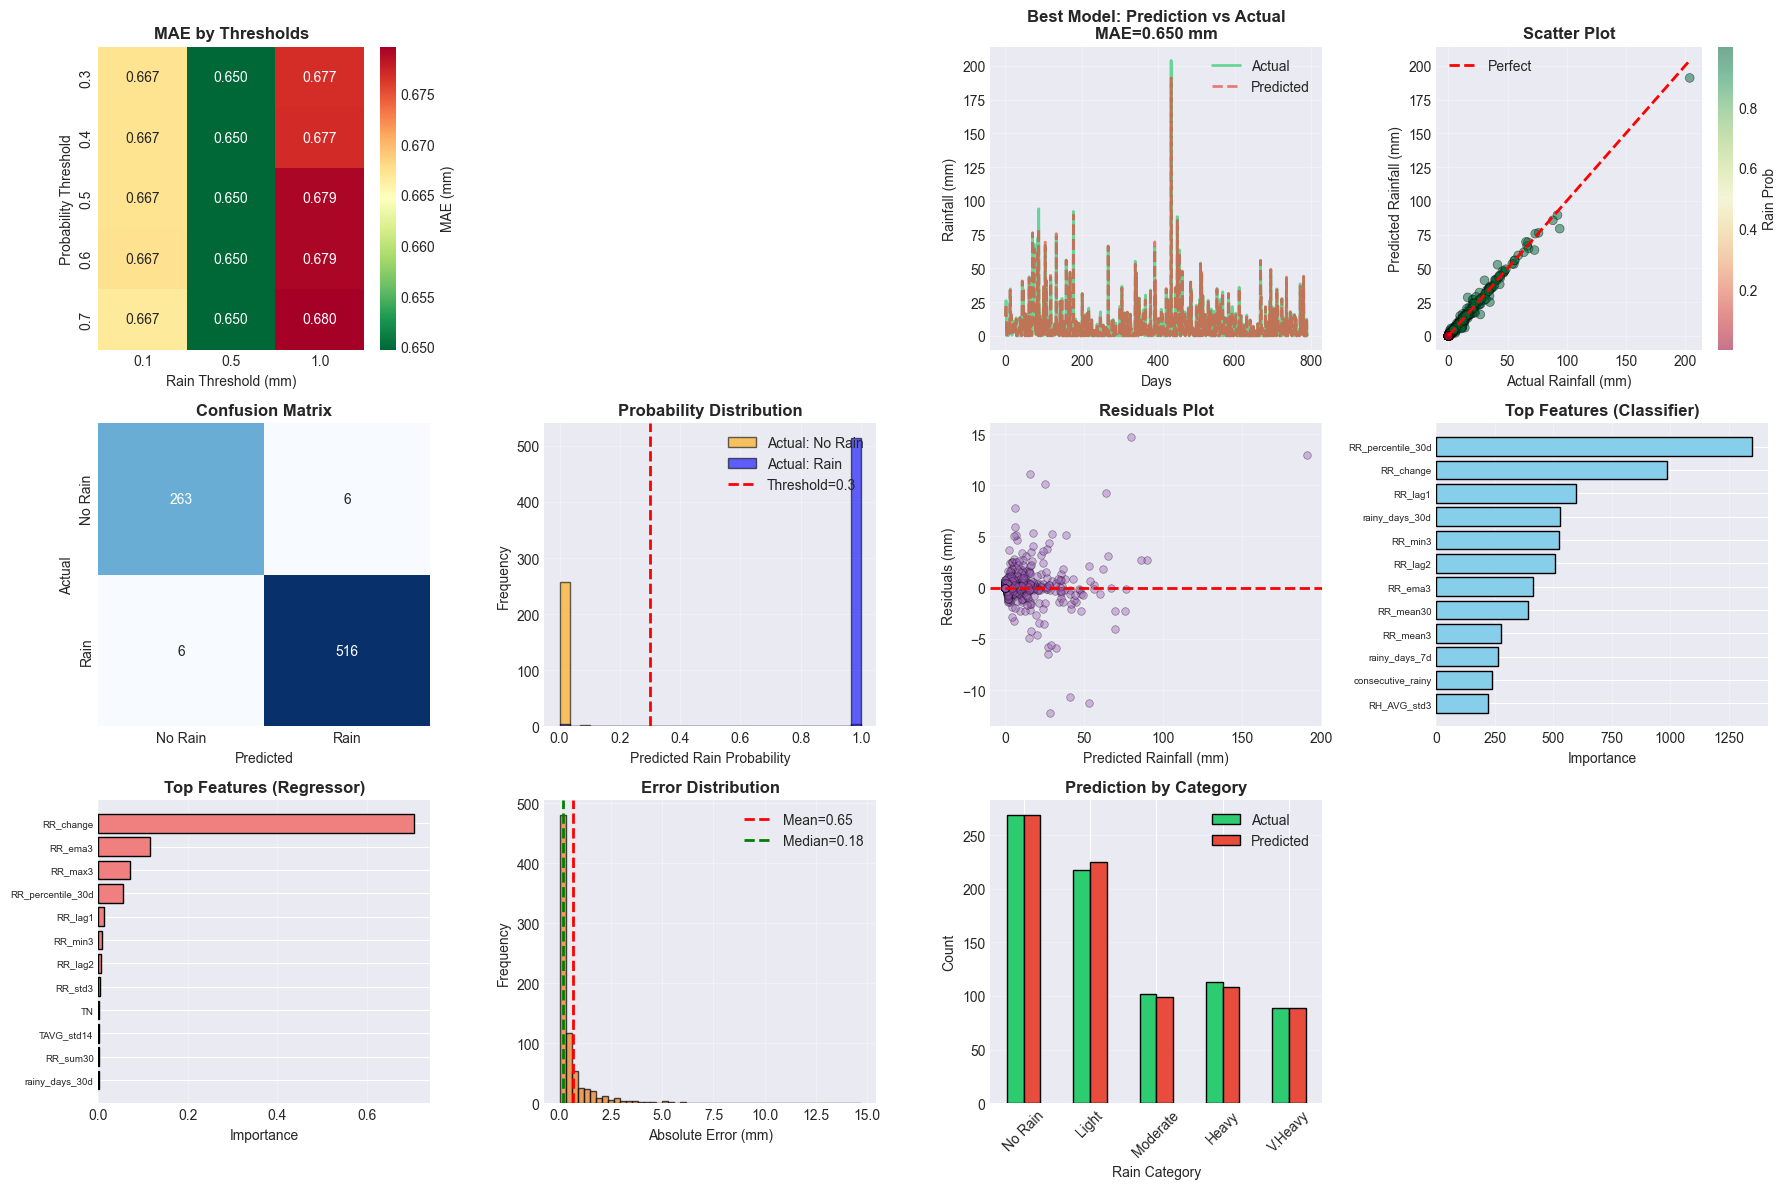

In [57]:
fig = plt.figure(figsize=(18, 12))

# Plot 1: MAE vs Thresholds Heatmap
plt.subplot(3, 4, 1)
pivot_mae = results_df.pivot(index='prob_threshold', columns='rain_threshold', values='mae')
sns.heatmap(pivot_mae, annot=True, fmt='.3f', cmap='RdYlGn_r', cbar_kws={'label': 'MAE (mm)'})
plt.title('MAE by Thresholds', fontweight='bold')
plt.xlabel('Rain Threshold (mm)')
plt.ylabel('Probability Threshold')


# Plot 2: Prediction vs Actual
plt.subplot(3, 4, 3)
plt.plot(y_reg_test.values, label='Actual', linewidth=2, alpha=0.7, color='#2ecc71')
plt.plot(y_pred_final, label='Predicted', linestyle='--', linewidth=2, alpha=0.7, color='#e74c3c')
plt.title(f'Best Model: Prediction vs Actual\nMAE={best_config["mae"]:.3f} mm', fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Scatter Plot
plt.subplot(3, 4, 4)
scatter = plt.scatter(y_reg_test, y_pred_final, alpha=0.5, s=40, c=rain_probability, 
                     cmap='RdYlGn', edgecolors='k', linewidth=0.5)
plt.plot([0, y_reg_test.max()], [0, y_reg_test.max()], 'r--', lw=2, label='Perfect')
plt.xlabel('Actual Rainfall (mm)')
plt.ylabel('Predicted Rainfall (mm)')
plt.title('Scatter Plot', fontweight='bold')
plt.colorbar(scatter, label='Rain Prob')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Confusion Matrix
plt.subplot(3, 4, 5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix', fontweight='bold')

# Plot 5: Rain Probability Distribution
plt.subplot(3, 4, 6)
plt.hist(rain_probability[y_cls_test == 0], bins=30, alpha=0.6, label='Actual: No Rain', color='orange', edgecolor='black')
plt.hist(rain_probability[y_cls_test == 1], bins=30, alpha=0.6, label='Actual: Rain', color='blue', edgecolor='black')
plt.axvline(x=PROB_THRESHOLD, color='r', linestyle='--', linewidth=2, label=f'Threshold={PROB_THRESHOLD}')
plt.xlabel('Predicted Rain Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Residuals
plt.subplot(3, 4, 7)
residuals = y_reg_test.values - y_pred_final
plt.scatter(y_pred_final, residuals, alpha=0.4, s=30, c='#9b59b6', edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Rainfall (mm)')
plt.ylabel('Residuals (mm)')
plt.title('Residuals Plot', fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 7: Feature Importance (Classifier)
plt.subplot(3, 4, 8)
cls_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False).head(12)
plt.barh(range(len(cls_importance)), cls_importance['importance'], color='skyblue', edgecolor='black')
plt.yticks(range(len(cls_importance)), cls_importance['feature'], fontsize=7)
plt.xlabel('Importance')
plt.title('Top Features (Classifier)', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Plot 8: Feature Importance (Regressor)
plt.subplot(3, 4, 9)
reg_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': regressor.feature_importances_
}).sort_values('importance', ascending=False).head(12)
plt.barh(range(len(reg_importance)), reg_importance['importance'], color='lightcoral', edgecolor='black')
plt.yticks(range(len(reg_importance)), reg_importance['feature'], fontsize=7)
plt.xlabel('Importance')
plt.title('Top Features (Regressor)', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Plot 10: Error Distribution
plt.subplot(3, 4, 10)
abs_errors = np.abs(residuals)
plt.hist(abs_errors, bins=50, edgecolor='black', alpha=0.7, color='#e67e22')
plt.xlabel('Absolute Error (mm)')
plt.ylabel('Frequency')
plt.title('Error Distribution', fontweight='bold')
plt.axvline(x=np.mean(abs_errors), color='r', linestyle='--', linewidth=2, label=f'Mean={np.mean(abs_errors):.2f}')
plt.axvline(x=np.median(abs_errors), color='g', linestyle='--', linewidth=2, label=f'Median={np.median(abs_errors):.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 11: Performance by Category
plt.subplot(3, 4, 11)
categories_bins = [-0.1, 0.5, 5, 10, 20, 100]
categories_labels = ['No Rain', 'Light', 'Moderate', 'Heavy', 'V.Heavy']
actual_cat = pd.cut(y_reg_test, bins=categories_bins, labels=categories_labels)
pred_cat = pd.cut(y_pred_final, bins=categories_bins, labels=categories_labels)

cat_df = pd.DataFrame({
    'Actual': actual_cat.value_counts().sort_index(),
    'Predicted': pred_cat.value_counts().sort_index()
})
cat_df.plot(kind='bar', ax=plt.gca(), color=['#2ecc71', '#e74c3c'], edgecolor='black')
plt.xlabel('Rain Category')
plt.ylabel('Count')
plt.title('Prediction by Category', fontweight='bold')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.show()

In [58]:

print("PREDIKSI CURAH HUJAN ESOK HARI")


X = best_config['X']
latest_data = X.iloc[-1:].copy()

# Stage 1: Prediksi probabilitas hujan
rain_prob_tomorrow = classifier.predict_proba(latest_data)[0, 1]
will_rain = rain_prob_tomorrow > PROB_THRESHOLD

print(f"Probabilitas Hujan: {rain_prob_tomorrow*100:.1f}%")
print(f"Threshold: {PROB_THRESHOLD*100:.0f}%")

if will_rain:
    # Stage 2: Prediksi intensitas
    predicted_rain = regressor.predict(latest_data)[0]
    predicted_rain = max(0, predicted_rain)
    
    print(f"\nPREDIKSI: AKAN HUJAN")
    print(f"Intensitas Prediksi: {predicted_rain:.2f} mm")
    
    # Confidence interval berdasarkan error historis
    std_error = np.std(y_reg_test[rain_mask_test] - y_pred_final[rain_mask_test])
    lower = max(0, predicted_rain - std_error)
    upper = predicted_rain + std_error
    print(f"📊 Range Prediksi: {lower:.2f} - {upper:.2f} mm")
    
    if predicted_rain < 1:
        status = "Hujan sangat ringan"
    elif predicted_rain < 5:
        status = "Hujan ringan"
    elif predicted_rain < 10:
        status = "Hujan sedang"
    elif predicted_rain < 20:
        status = "Hujan lebat"
    else:
        status = "Hujan sangat lebat"
    
    print(f"Status: {status}")
else:
    predicted_rain = 0.0
    print(f"\nPREDIKSI: TIDAK HUJAN")
    print(f"Intensitas Prediksi: {predicted_rain:.2f} mm")

print(f"\nModel Configuration:")
print(f"   Rain Threshold: {RAIN_THRESHOLD} mm")
print(f"   Probability Threshold: {PROB_THRESHOLD}")
print(f"   Model MAE: {best_config['mae']:.3f} mm")
print(f"   Model R²: {best_config['r2']:.3f}")


PREDIKSI CURAH HUJAN ESOK HARI
Probabilitas Hujan: 0.0%
Threshold: 30%

PREDIKSI: TIDAK HUJAN
Intensitas Prediksi: 0.00 mm

Model Configuration:
   Rain Threshold: 0.5 mm
   Probability Threshold: 0.3
   Model MAE: 0.650 mm
   Model R²: 0.988


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 96 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   TANGGAL             3983 non-null   datetime64[ns]
 1   TN                  3983 non-null   float64       
 2   TX                  3983 non-null   float64       
 3   TAVG                3983 non-null   float64       
 4   RH_AVG              3983 non-null   float64       
 5   RR                  3983 non-null   float64       
 6   SS                  3983 non-null   float64       
 7   FF_X                3983 non-null   int64         
 8   DDD_X               3983 non-null   int64         
 9   FF_AVG              3983 non-null   int64         
 10  DDD_CAR             3983 non-null   int64         
 11  month               3983 non-null   int32         
 12  day                 3983 non-null   int32         
 13  dayofyear           3983 non-null   int32       

In [60]:
new_df = df.to_excel('Test.xlsx')


📊 SPLITTING DATA (NO DATA LEAKAGE)
📌 Total data: 3983
📌 Train: 2788 (70.0%)
📌 Val:   597 (15.0%)
📌 Test:  598 (15.0%)

🔧 FEATURE ENGINEERING (SAFE)
🔧 Creating features... (Training mode: True)
✅ Created 102 features total
🔧 Creating features... (Training mode: False)
✅ Created 102 features total
🔧 Creating features... (Training mode: False)
✅ Created 102 features total

✅ After cleaning:
   Train: 2781
   Val:   590
   Test:  591

🔍 SEARCHING FOR OPTIMAL THRESHOLDS...

📌 Testing RAIN_THRESHOLD = 0.1 mm
   Prob=0.3 → MAE=1.371, RMSE=6.712, R²=0.902
   Prob=0.4 → MAE=1.371, RMSE=6.712, R²=0.902
   Prob=0.5 → MAE=1.371, RMSE=6.712, R²=0.902
   Prob=0.6 → MAE=1.371, RMSE=6.712, R²=0.902
   Prob=0.7 → MAE=1.371, RMSE=6.712, R²=0.902

📌 Testing RAIN_THRESHOLD = 0.5 mm
   Prob=0.3 → MAE=1.255, RMSE=6.815, R²=0.899
   Prob=0.4 → MAE=1.253, RMSE=6.815, R²=0.899
   Prob=0.5 → MAE=1.252, RMSE=6.814, R²=0.899
   Prob=0.6 → MAE=1.252, RMSE=6.814, R²=0.899
   Prob=0.7 → MAE=1.252, RMSE=6.814, R²=0.

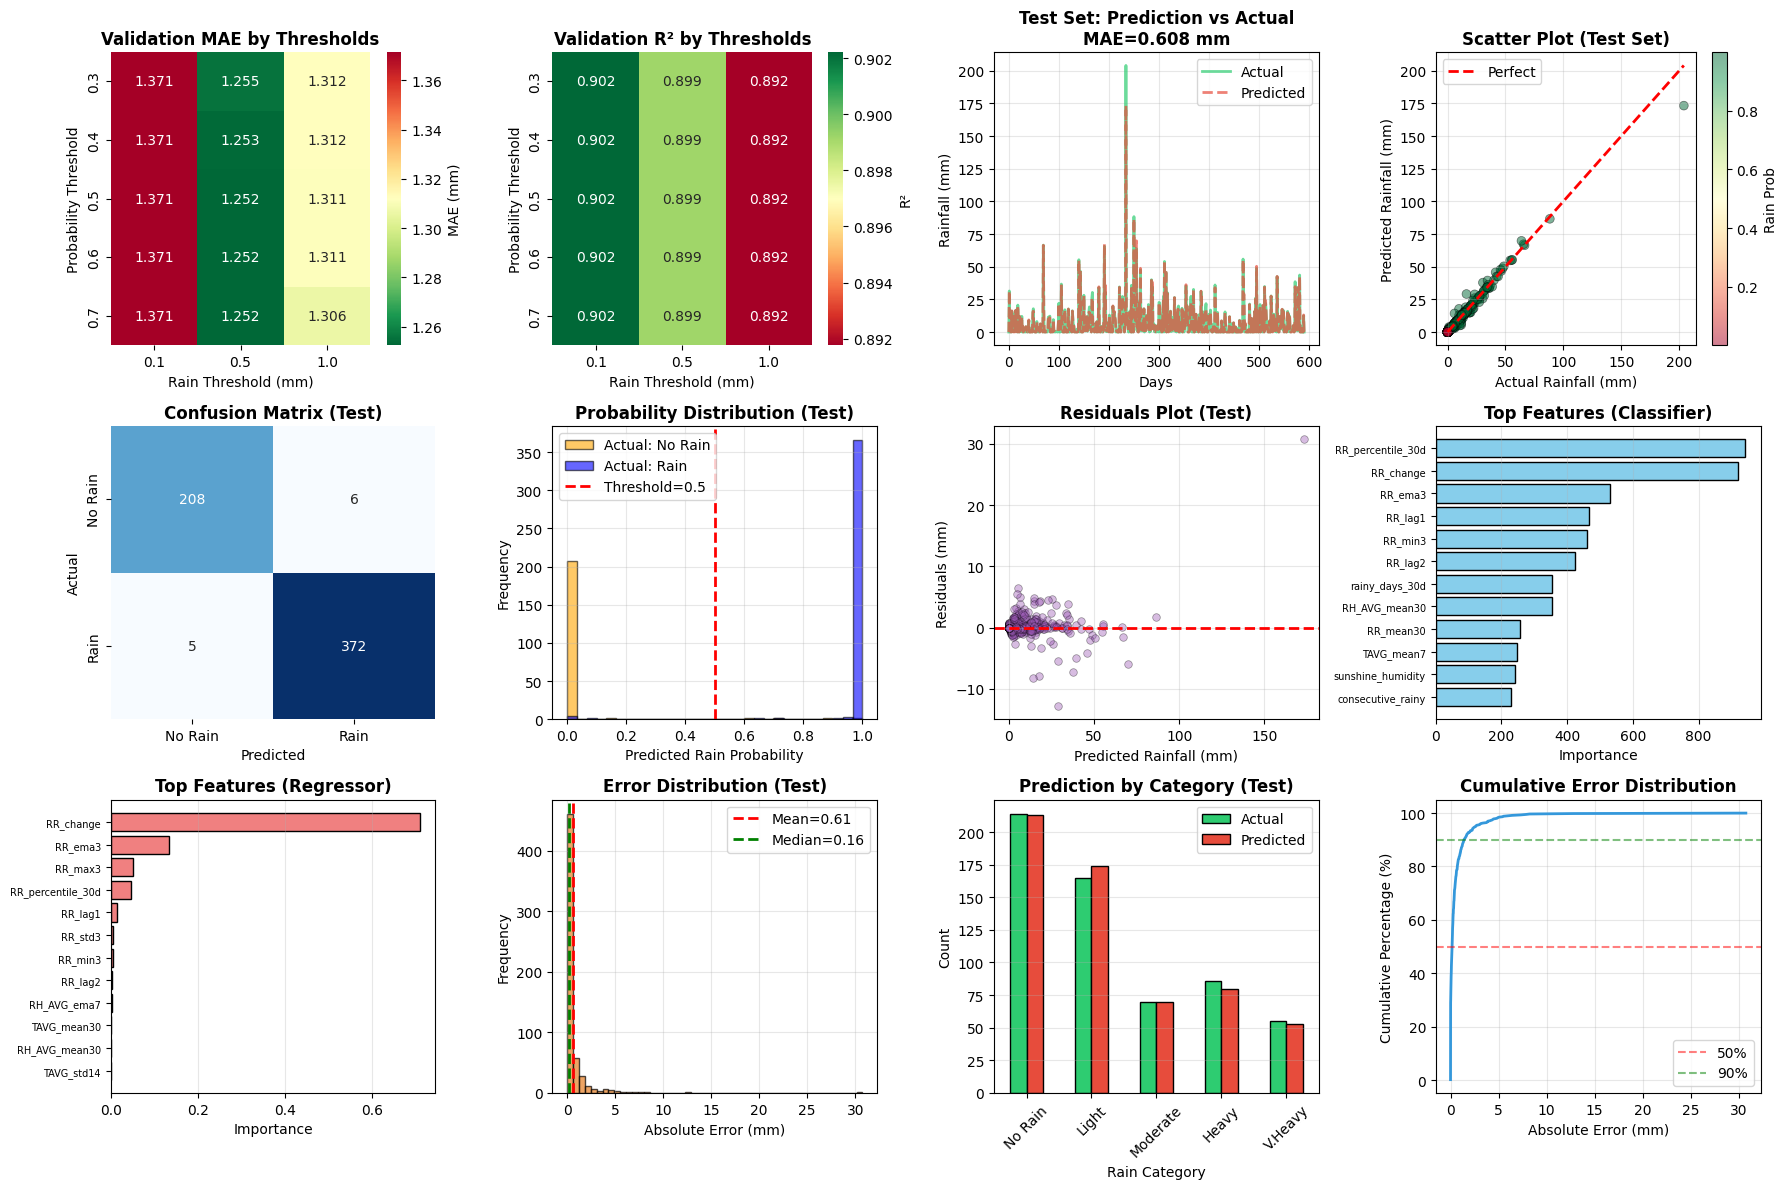


🌦️  PREDIKSI CURAH HUJAN 7 HARI KE DEPAN (RECURSIVE)
🔧 Creating features... (Training mode: False)
✅ Created 103 features total
🔧 Creating features... (Training mode: False)
✅ Created 103 features total
🔧 Creating features... (Training mode: False)
✅ Created 103 features total
🔧 Creating features... (Training mode: False)
✅ Created 103 features total
🔧 Creating features... (Training mode: False)
✅ Created 103 features total
🔧 Creating features... (Training mode: False)
✅ Created 103 features total
🔧 Creating features... (Training mode: False)
✅ Created 103 features total

📊 HASIL PREDIKSI 7 HARI:

☀️ Hari +1 (2025-11-11)
   Probabilitas Hujan : 0.0%
   Intensitas Prediksi: 0.00 mm
   Kategori          : Tidak Hujan

☀️ Hari +2 (2025-11-12)
   Probabilitas Hujan : 0.0%
   Intensitas Prediksi: 0.00 mm
   Kategori          : Tidak Hujan

☀️ Hari +3 (2025-11-13)
   Probabilitas Hujan : 0.0%
   Intensitas Prediksi: 0.00 mm
   Kategori          : Tidak Hujan

☀️ Hari +4 (2025-11-14)
   Prob

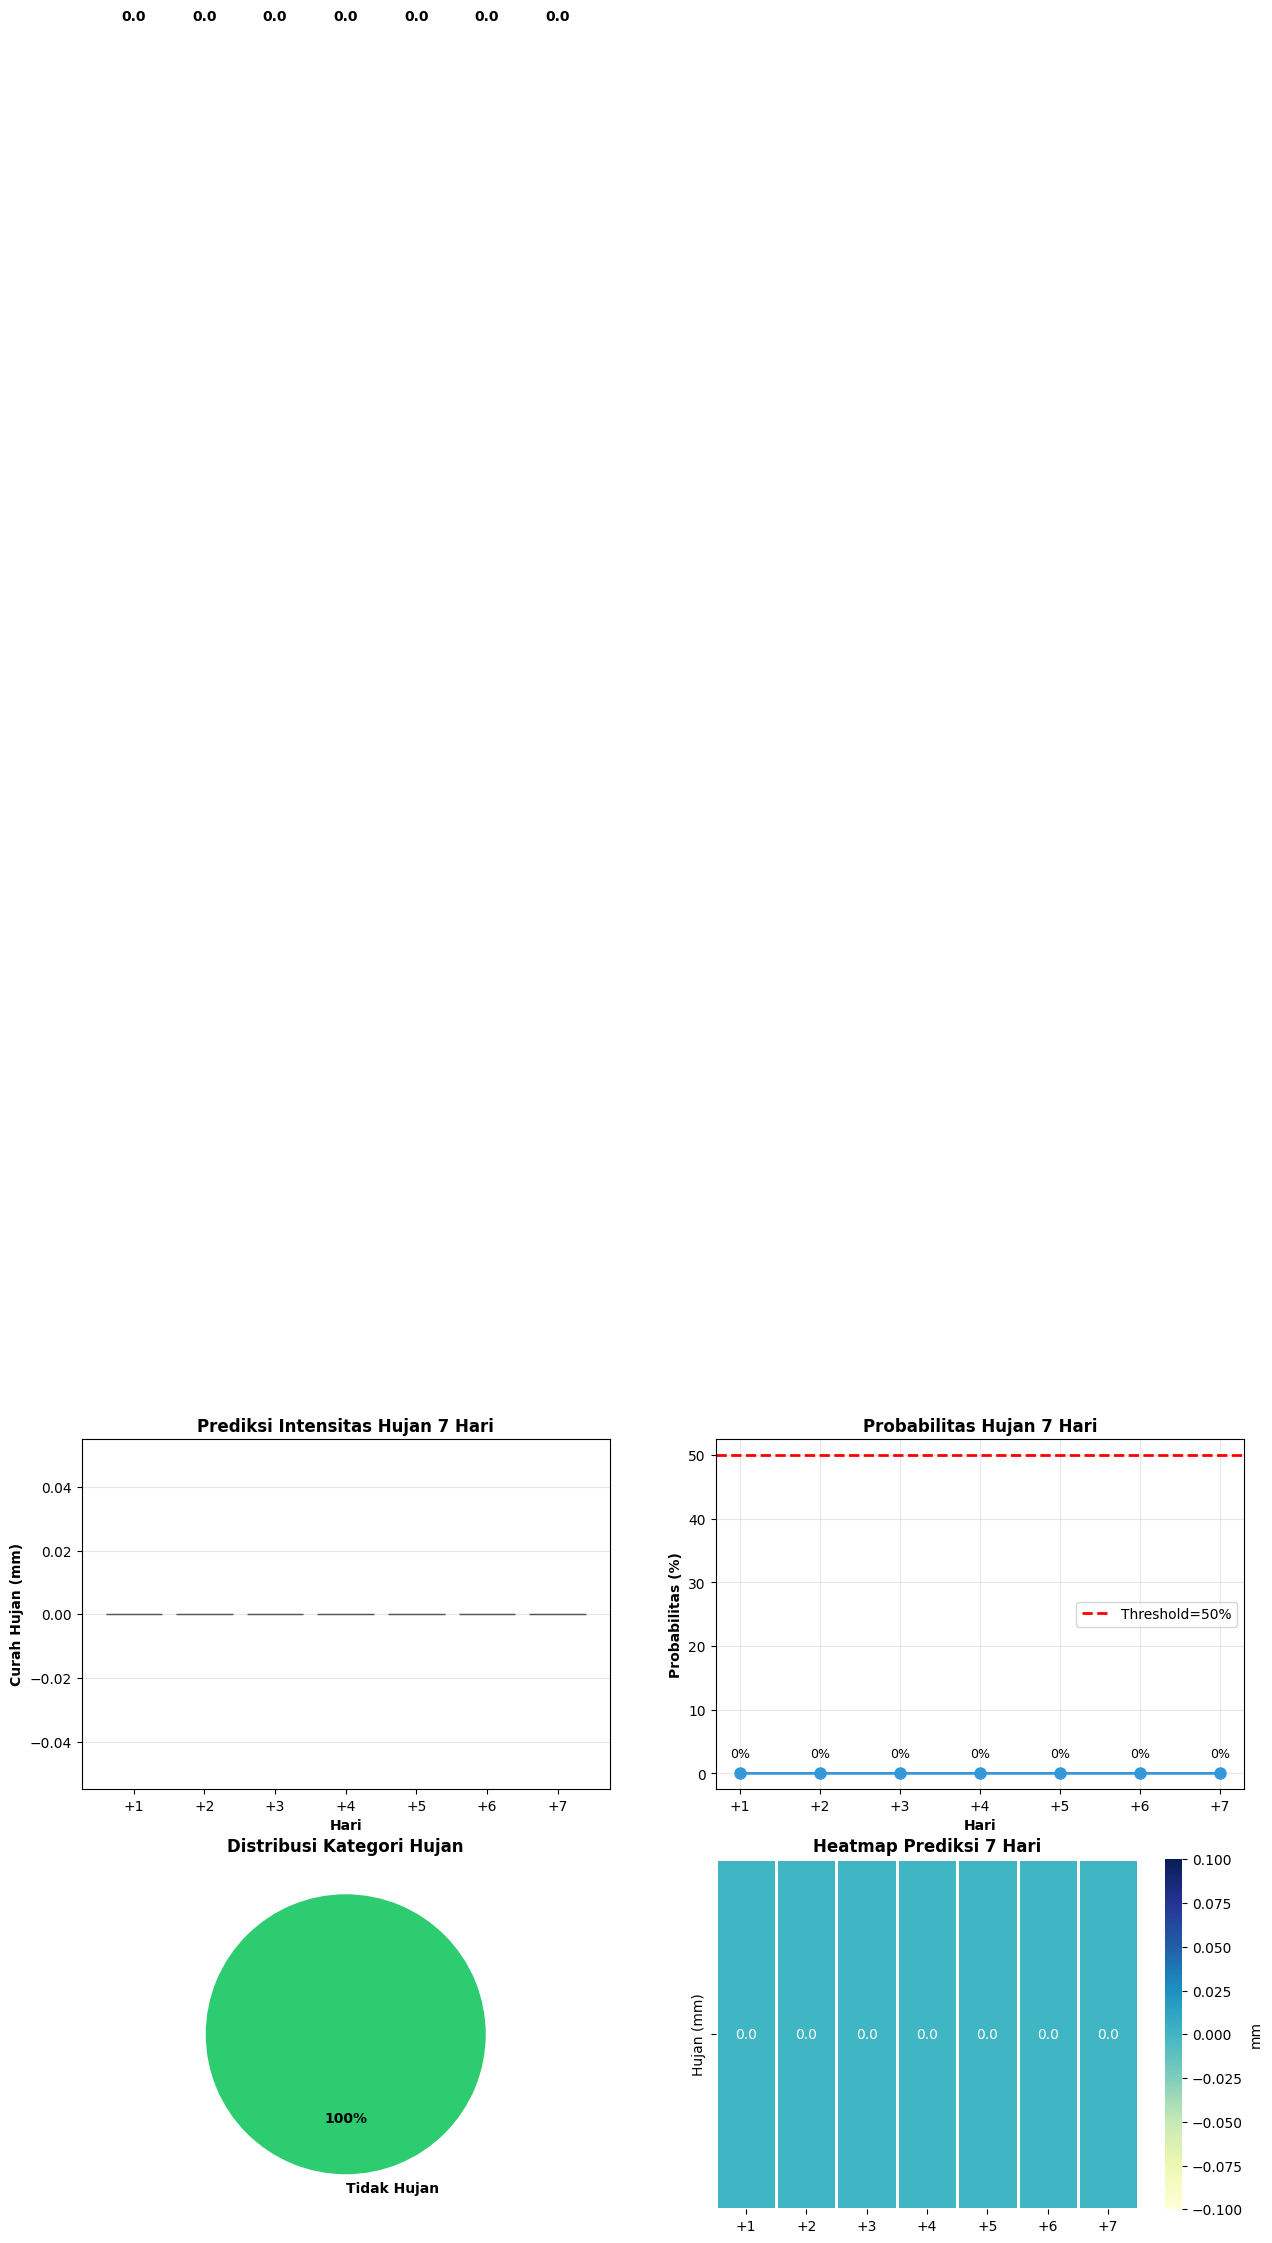


⚠️  CATATAN PENTING:
📉 Akurasi prediksi MENURUN seiring bertambahnya hari:
   • Hari +1 & +2  : Akurasi relatif tinggi
   • Hari +3 & +4  : Akurasi sedang
   • Hari +5 - +7  : Akurasi rendah (gunakan sebagai indikasi)

💡 Alasan:
   • Error akumulasi dari prediksi sebelumnya
   • Asumsi cuaca lain (temp, humidity, dll) tetap stabil
   • Tidak ada informasi cuaca real-time

🎯 Rekomendasi:
   • Gunakan prediksi +1 hingga +3 hari untuk keputusan penting
   • Prediksi +4 hingga +7 hari sebagai TREND indikasi
   • Update prediksi setiap hari dengan data terbaru

⚙️  Model Configuration:
   Rain Threshold: 0.5 mm
   Probability Threshold: 0.5
   Validation MAE: 1.252 mm
   Test MAE: 0.608 mm
   Test R²: 0.983


In [4]:
# ==============================================
# TWO-STAGE MODEL + THRESHOLD TUNING
# FIXED: NO DATA LEAKAGE
# Split: Train 70%, Val 15%, Test 15%
# ==============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==============================================
# 1️⃣ FEATURE ENGINEERING (SAFE VERSION)
# ==============================================

def create_safe_features(df, fit_stats=None):
    """
    Membuat fitur-fitur yang AMAN dari data leakage
    
    Parameters:
    - df: DataFrame input
    - fit_stats: Dictionary berisi statistics dari train set (untuk val/test)
    
    Returns:
    - df: DataFrame dengan features baru
    - stats: Dictionary statistics (jika fit_stats=None)
    """
    df = df.copy()
    is_training = (fit_stats is None)
    
    if is_training:
        fit_stats = {}
    
    print(f"🔧 Creating features... (Training mode: {is_training})")
    
    # ===== 1. FITUR TEMPORAL (SELALU AMAN) =====
    df['month'] = df['TANGGAL'].dt.month
    df['day'] = df['TANGGAL'].dt.day
    df['dayofyear'] = df['TANGGAL'].dt.dayofyear
    df['week'] = df['TANGGAL'].dt.isocalendar().week
    df['quarter'] = df['TANGGAL'].dt.quarter
    df['dayofweek'] = df['TANGGAL'].dt.dayofweek
    
    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    # Musim hujan Indonesia
    df['is_rainy_season'] = df['month'].apply(lambda x: 1 if x in [11, 12, 1, 2, 3] else 0)
    
    # ===== 2. LAG FEATURES (AMAN - hanya lihat ke belakang) =====
    for i in range(1, 8):
        df[f'RR_lag{i}'] = df['RR'].shift(i)
    
    for col in ['TAVG', 'RH_AVG', 'FF_AVG', 'SS']:
        if col in df.columns:
            df[f'{col}_lag1'] = df[col].shift(1)
            df[f'{col}_lag2'] = df[col].shift(2)
            df[f'{col}_lag3'] = df[col].shift(3)
    
    # ===== 3. ROLLING STATISTICS (AMAN - min_periods=1, hanya lihat ke belakang) =====
    windows = [3, 7, 14, 30]
    
    for window in windows:
        df[f'RR_mean{window}'] = df['RR'].rolling(window=window, min_periods=1).mean()
        df[f'RR_max{window}'] = df['RR'].rolling(window=window, min_periods=1).max()
        df[f'RR_min{window}'] = df['RR'].rolling(window=window, min_periods=1).min()
        df[f'RR_std{window}'] = df['RR'].rolling(window=window, min_periods=1).std()
        df[f'RR_sum{window}'] = df['RR'].rolling(window=window, min_periods=1).sum()
        
        df[f'TAVG_mean{window}'] = df['TAVG'].rolling(window=window, min_periods=1).mean()
        df[f'TAVG_std{window}'] = df['TAVG'].rolling(window=window, min_periods=1).std()
        
        df[f'RH_AVG_mean{window}'] = df['RH_AVG'].rolling(window=window, min_periods=1).mean()
        df[f'RH_AVG_std{window}'] = df['RH_AVG'].rolling(window=window, min_periods=1).std()
    
    # ===== 4. TREND FEATURES =====
    df['consecutive_rainy'] = (df['RR'] > 0).groupby((df['RR'] == 0).cumsum()).cumsum()
    df['consecutive_dry'] = (df['RR'] == 0).groupby((df['RR'] > 0).cumsum()).cumsum()
    
    df['rainy_days_7d'] = df['RR'].rolling(window=7, min_periods=1).apply(lambda x: (x > 0).sum())
    df['rainy_days_14d'] = df['RR'].rolling(window=14, min_periods=1).apply(lambda x: (x > 0).sum())
    df['rainy_days_30d'] = df['RR'].rolling(window=30, min_periods=1).apply(lambda x: (x > 0).sum())
    
    df['is_rainy_yesterday'] = (df['RR_lag1'] > 0).astype(int)
    df['is_rainy_2days_ago'] = (df['RR_lag2'] > 0).astype(int)
    
    # ===== 5. INTERACTION FEATURES =====
    df['temp_humidity'] = df['TAVG'] * df['RH_AVG']
    df['temp_range'] = df['TX'] - df['TN']
    df['sunshine_humidity'] = df['SS'] * (100 - df['RH_AVG'])
    df['wind_humidity'] = df['FF_AVG'] * df['RH_AVG']
    df['temp_wind'] = df['TAVG'] * df['FF_AVG']
    
    # ===== 6. EXPONENTIAL MOVING AVERAGE (AMAN dengan adjust=False) =====
    df['RR_ema3'] = df['RR'].ewm(span=3, adjust=False).mean()
    df['RR_ema7'] = df['RR'].ewm(span=7, adjust=False).mean()
    df['RH_AVG_ema7'] = df['RH_AVG'].ewm(span=7, adjust=False).mean()
    
    # ===== 7. RATE OF CHANGE =====
    df['RR_change'] = df['RR'].diff()
    df['TAVG_change'] = df['TAVG'].diff()
    df['RH_AVG_change'] = df['RH_AVG'].diff()
    
    # ===== 8. PERCENTILE FEATURES =====
    df['RR_percentile_30d'] = df['RR'].rolling(window=30, min_periods=1).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
    )
    
    # ===== 9. NORMALIZATION (FIT di train, TRANSFORM di val/test) =====
    numeric_cols = ['TAVG', 'RH_AVG', 'FF_AVG', 'SS', 'TX', 'TN']
    
    for col in numeric_cols:
        if col in df.columns:
            if is_training:
                # Training: simpan mean & std
                fit_stats[f'{col}_mean'] = df[col].mean()
                fit_stats[f'{col}_std'] = df[col].std()
            
            # Normalize menggunakan statistics dari training
            mean_val = fit_stats[f'{col}_mean']
            std_val = fit_stats[f'{col}_std']
            df[f'{col}_norm'] = (df[col] - mean_val) / (std_val + 1e-8)
    
    print(f"✅ Created {len(df.columns)} features total")
    
    if is_training:
        return df, fit_stats
    else:
        return df

# ==============================================
# 2️⃣ SPLIT DATA: Train 70%, Val 15%, Test 15%
# ==============================================

print("\n" + "="*70)
print("📊 SPLITTING DATA (NO DATA LEAKAGE)")
print("="*70)

# Hitung index split berdasarkan waktu
total_len = len(df)
train_end = int(total_len * 0.70)
val_end = int(total_len * 0.85)

# Split chronologically
df_train_raw = df.iloc[:train_end].copy()
df_val_raw = df.iloc[train_end:val_end].copy()
df_test_raw = df.iloc[val_end:].copy()

print(f"📌 Total data: {total_len}")
print(f"📌 Train: {len(df_train_raw)} ({len(df_train_raw)/total_len*100:.1f}%)")
print(f"📌 Val:   {len(df_val_raw)} ({len(df_val_raw)/total_len*100:.1f}%)")
print(f"📌 Test:  {len(df_test_raw)} ({len(df_test_raw)/total_len*100:.1f}%)")

# ==============================================
# 3️⃣ FEATURE ENGINEERING PER SPLIT
# ==============================================

print("\n" + "="*70)
print("🔧 FEATURE ENGINEERING (SAFE)")
print("="*70)

# Train: Fit & Transform
df_train, train_stats = create_safe_features(df_train_raw, fit_stats=None)

# Val: Transform only (gunakan stats dari train)
df_val = create_safe_features(df_val_raw, fit_stats=train_stats)

# Test: Transform only (gunakan stats dari train)
df_test = create_safe_features(df_test_raw, fit_stats=train_stats)

# Drop NaN (hanya dari lag/rolling features)
df_train_clean = df_train.dropna().reset_index(drop=True)
df_val_clean = df_val.dropna().reset_index(drop=True)
df_test_clean = df_test.dropna().reset_index(drop=True)

print(f"\n✅ After cleaning:")
print(f"   Train: {len(df_train_clean)}")
print(f"   Val:   {len(df_val_clean)}")
print(f"   Test:  {len(df_test_clean)}")

# ==============================================
# 4️⃣ GRID SEARCH UNTUK THRESHOLD TERBAIK
# ==============================================

print("\n" + "="*70)
print("🔍 SEARCHING FOR OPTIMAL THRESHOLDS...")
print("="*70)

# Test berbagai kombinasi threshold
rain_thresholds = [0.1, 0.5, 1.0]  # mm
prob_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

best_mae = float('inf')
best_config = {}
results_list = []

for RAIN_THRESHOLD in rain_thresholds:
    print(f"\n📌 Testing RAIN_THRESHOLD = {RAIN_THRESHOLD} mm")
    
    # Create target untuk klasifikasi di semua sets
    df_train_clean['is_rain'] = (df_train_clean['RR'] > RAIN_THRESHOLD).astype(int)
    df_val_clean['is_rain'] = (df_val_clean['RR'] > RAIN_THRESHOLD).astype(int)
    df_test_clean['is_rain'] = (df_test_clean['RR'] > RAIN_THRESHOLD).astype(int)
    
    # Pisahkan fitur & target
    exclude_cols = ['TANGGAL', 'RR', 'is_rain']
    feature_cols = [col for col in df_train_clean.columns if col not in exclude_cols]
    
    # Train set
    X_train = df_train_clean[feature_cols]
    y_reg_train = df_train_clean['RR']
    y_cls_train = df_train_clean['is_rain']
    
    # Val set
    X_val = df_val_clean[feature_cols]
    y_reg_val = df_val_clean['RR']
    y_cls_val = df_val_clean['is_rain']
    
    # Test set
    X_test = df_test_clean[feature_cols]
    y_reg_test = df_test_clean['RR']
    y_cls_test = df_test_clean['is_rain']
    
    # ===== TRAIN CLASSIFIER =====
    classifier = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=50,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    )
    
    classifier.fit(X_train, y_cls_train)
    
    # Prediksi probabilitas di validation set
    rain_probability_val = classifier.predict_proba(X_val)[:, 1]
    
    # ===== TRAIN REGRESSOR (hanya pada hari hujan) =====
    rain_mask_train = y_reg_train > RAIN_THRESHOLD
    X_train_rain = X_train[rain_mask_train]
    y_train_rain = y_reg_train[rain_mask_train]
    
    regressor = GradientBoostingRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=7,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=0.8,
        loss='huber',
        alpha=0.9,
        random_state=42
    )
    
    regressor.fit(X_train_rain, y_train_rain)
    
    # ===== TEST BERBAGAI PROBABILITY THRESHOLD DI VALIDATION SET =====
    for PROB_THRESHOLD in prob_thresholds:
        # Two-stage prediction
        y_pred_val = np.zeros(len(X_val))
        
        for i in range(len(X_val)):
            if rain_probability_val[i] > PROB_THRESHOLD:
                rain_amount = regressor.predict(X_val.iloc[[i]])[0]
                y_pred_val[i] = max(0, rain_amount)
            else:
                y_pred_val[i] = 0.0
        
        # Evaluasi di validation set
        mae = mean_absolute_error(y_reg_val, y_pred_val)
        rmse = np.sqrt(mean_squared_error(y_reg_val, y_pred_val))
        r2 = r2_score(y_reg_val, y_pred_val)
        
        # Simpan hasil
        results_list.append({
            'rain_threshold': RAIN_THRESHOLD,
            'prob_threshold': PROB_THRESHOLD,
            'mae': mae,
            'rmse': rmse,
            'r2': r2
        })
        
        print(f"   Prob={PROB_THRESHOLD:.1f} → MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")
        
        # Update best config berdasarkan validation set
        if mae < best_mae:
            best_mae = mae
            best_config = {
                'rain_threshold': RAIN_THRESHOLD,
                'prob_threshold': PROB_THRESHOLD,
                'mae_val': mae,
                'rmse_val': rmse,
                'r2_val': r2,
                'classifier': classifier,
                'regressor': regressor,
                'feature_cols': feature_cols,
                'rain_mask_train': rain_mask_train
            }

# ==============================================
# 5️⃣ EVALUASI FINAL DI TEST SET
# ==============================================

print("\n" + "="*70)
print("🏆 BEST CONFIGURATION (from Validation)")
print("="*70)
print(f"Rain Threshold      : {best_config['rain_threshold']} mm")
print(f"Probability Threshold: {best_config['prob_threshold']}")
print(f"Validation MAE      : {best_config['mae_val']:.3f} mm")
print(f"Validation RMSE     : {best_config['rmse_val']:.3f} mm")
print(f"Validation R²       : {best_config['r2_val']:.3f}")

# Gunakan config terbaik untuk evaluasi di test set
RAIN_THRESHOLD = best_config['rain_threshold']
PROB_THRESHOLD = best_config['prob_threshold']
classifier = best_config['classifier']
regressor = best_config['regressor']
feature_cols = best_config['feature_cols']

# Prepare test data
df_test_clean['is_rain'] = (df_test_clean['RR'] > RAIN_THRESHOLD).astype(int)
X_test = df_test_clean[feature_cols]
y_reg_test = df_test_clean['RR']
y_cls_test = df_test_clean['is_rain']

# Prediksi di test set
rain_probability_test = classifier.predict_proba(X_test)[:, 1]

y_pred_test = np.zeros(len(X_test))
for i in range(len(X_test)):
    if rain_probability_test[i] > PROB_THRESHOLD:
        rain_amount = regressor.predict(X_test.iloc[[i]])[0]
        y_pred_test[i] = max(0, rain_amount)
    else:
        y_pred_test[i] = 0.0

# Evaluasi final di test set
mae_test = mean_absolute_error(y_reg_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_reg_test, y_pred_test))
r2_test = r2_score(y_reg_test, y_pred_test)

print("\n" + "="*70)
print("📊 FINAL TEST SET PERFORMANCE")
print("="*70)
print(f"Test MAE            : {mae_test:.3f} mm")
print(f"Test RMSE           : {rmse_test:.3f} mm")
print(f"Test R²             : {r2_test:.3f}")
print("="*70)

# DataFrame hasil semua kombinasi
results_df = pd.DataFrame(results_list).sort_values('mae')
print("\n📊 Top 10 Configurations (from Validation):")
print(results_df.head(10).to_string(index=False))

# ==============================================
# 6️⃣ DETAIL EVALUATION
# ==============================================

# Classification metrics
y_cls_pred_test = (rain_probability_test > PROB_THRESHOLD).astype(int)
cls_accuracy = accuracy_score(y_cls_test, y_cls_pred_test)
f1 = f1_score(y_cls_test, y_cls_pred_test)

print("\n📊 Classification Performance (Test Set):")
print(f"   Accuracy: {cls_accuracy:.3f}")
print(f"   F1-Score: {f1:.3f}")
print("\n" + classification_report(y_cls_test, y_cls_pred_test, target_names=['No Rain', 'Rain']))

# Confusion Matrix
cm = confusion_matrix(y_cls_test, y_cls_pred_test)
print("🔢 Confusion Matrix:")
print(f"                Predicted")
print(f"              No Rain  Rain")
print(f"Actual No Rain  {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"       Rain     {cm[1,0]:5d}  {cm[1,1]:5d}")

# Performance pada hari hujan saja
rain_mask_test = y_reg_test > RAIN_THRESHOLD
if rain_mask_test.sum() > 0:
    mae_rainy = mean_absolute_error(y_reg_test[rain_mask_test], y_pred_test[rain_mask_test])
    rmse_rainy = np.sqrt(mean_squared_error(y_reg_test[rain_mask_test], y_pred_test[rain_mask_test]))
    print(f"\n📊 Performance on RAINY days only ({rain_mask_test.sum()} days):")
    print(f"   MAE  : {mae_rainy:.3f} mm")
    print(f"   RMSE : {rmse_rainy:.3f} mm")

# ==============================================
# 7️⃣ VISUALISASI KOMPREHENSIF
# ==============================================

fig = plt.figure(figsize=(18, 12))

# Plot 1: MAE vs Thresholds Heatmap
plt.subplot(3, 4, 1)
pivot_mae = results_df.pivot(index='prob_threshold', columns='rain_threshold', values='mae')
sns.heatmap(pivot_mae, annot=True, fmt='.3f', cmap='RdYlGn_r', cbar_kws={'label': 'MAE (mm)'})
plt.title('Validation MAE by Thresholds', fontweight='bold')
plt.xlabel('Rain Threshold (mm)')
plt.ylabel('Probability Threshold')

# Plot 2: R² vs Thresholds Heatmap
plt.subplot(3, 4, 2)
pivot_r2 = results_df.pivot(index='prob_threshold', columns='rain_threshold', values='r2')
sns.heatmap(pivot_r2, annot=True, fmt='.3f', cmap='RdYlGn', cbar_kws={'label': 'R²'})
plt.title('Validation R² by Thresholds', fontweight='bold')
plt.xlabel('Rain Threshold (mm)')
plt.ylabel('Probability Threshold')

# Plot 3: Prediction vs Actual (Test Set)
plt.subplot(3, 4, 3)
plt.plot(y_reg_test.values, label='Actual', linewidth=2, alpha=0.7, color='#2ecc71')
plt.plot(y_pred_test, label='Predicted', linestyle='--', linewidth=2, alpha=0.7, color='#e74c3c')
plt.title(f'Test Set: Prediction vs Actual\nMAE={mae_test:.3f} mm', fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Scatter Plot
plt.subplot(3, 4, 4)
scatter = plt.scatter(y_reg_test, y_pred_test, alpha=0.5, s=40, c=rain_probability_test, 
                     cmap='RdYlGn', edgecolors='k', linewidth=0.5)
plt.plot([0, y_reg_test.max()], [0, y_reg_test.max()], 'r--', lw=2, label='Perfect')
plt.xlabel('Actual Rainfall (mm)')
plt.ylabel('Predicted Rainfall (mm)')
plt.title('Scatter Plot (Test Set)', fontweight='bold')
plt.colorbar(scatter, label='Rain Prob')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Confusion Matrix
plt.subplot(3, 4, 5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)', fontweight='bold')

# Plot 6: Rain Probability Distribution
plt.subplot(3, 4, 6)
plt.hist(rain_probability_test[y_cls_test == 0], bins=30, alpha=0.6, label='Actual: No Rain', color='orange', edgecolor='black')
plt.hist(rain_probability_test[y_cls_test == 1], bins=30, alpha=0.6, label='Actual: Rain', color='blue', edgecolor='black')
plt.axvline(x=PROB_THRESHOLD, color='r', linestyle='--', linewidth=2, label=f'Threshold={PROB_THRESHOLD}')
plt.xlabel('Predicted Rain Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution (Test)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 7: Residuals
plt.subplot(3, 4, 7)
residuals = y_reg_test.values - y_pred_test
plt.scatter(y_pred_test, residuals, alpha=0.4, s=30, c='#9b59b6', edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Rainfall (mm)')
plt.ylabel('Residuals (mm)')
plt.title('Residuals Plot (Test)', fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 8: Feature Importance (Classifier)
plt.subplot(3, 4, 8)
cls_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False).head(12)
plt.barh(range(len(cls_importance)), cls_importance['importance'], color='skyblue', edgecolor='black')
plt.yticks(range(len(cls_importance)), cls_importance['feature'], fontsize=7)
plt.xlabel('Importance')
plt.title('Top Features (Classifier)', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Plot 9: Feature Importance (Regressor)
plt.subplot(3, 4, 9)
reg_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': regressor.feature_importances_
}).sort_values('importance', ascending=False).head(12)
plt.barh(range(len(reg_importance)), reg_importance['importance'], color='lightcoral', edgecolor='black')
plt.yticks(range(len(reg_importance)), reg_importance['feature'], fontsize=7)
plt.xlabel('Importance')
plt.title('Top Features (Regressor)', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Plot 10: Error Distribution
plt.subplot(3, 4, 10)
abs_errors = np.abs(residuals)
plt.hist(abs_errors, bins=50, edgecolor='black', alpha=0.7, color='#e67e22')
plt.xlabel('Absolute Error (mm)')
plt.ylabel('Frequency')
plt.title('Error Distribution (Test)', fontweight='bold')
plt.axvline(x=np.mean(abs_errors), color='r', linestyle='--', linewidth=2, label=f'Mean={np.mean(abs_errors):.2f}')
plt.axvline(x=np.median(abs_errors), color='g', linestyle='--', linewidth=2, label=f'Median={np.median(abs_errors):.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 11: Performance by Category
plt.subplot(3, 4, 11)
categories_bins = [-0.1, 0.5, 5, 10, 20, 100]
categories_labels = ['No Rain', 'Light', 'Moderate', 'Heavy', 'V.Heavy']
actual_cat = pd.cut(y_reg_test, bins=categories_bins, labels=categories_labels)
pred_cat = pd.cut(y_pred_test, bins=categories_bins, labels=categories_labels)

cat_df = pd.DataFrame({
    'Actual': actual_cat.value_counts().sort_index(),
    'Predicted': pred_cat.value_counts().sort_index()
})
cat_df.plot(kind='bar', ax=plt.gca(), color=['#2ecc71', '#e74c3c'], edgecolor='black')
plt.xlabel('Rain Category')
plt.ylabel('Count')
plt.title('Prediction by Category (Test)', fontweight='bold')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Plot 12: Cumulative Error
plt.subplot(3, 4, 12)
sorted_errors = np.sort(abs_errors)
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
plt.plot(sorted_errors, cumulative, linewidth=2, color='#3498db')
plt.xlabel('Absolute Error (mm)')
plt.ylabel('Cumulative Percentage (%)')
plt.title('Cumulative Error Distribution', fontweight='bold')
plt.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50%')
plt.axhline(y=90, color='g', linestyle='--', alpha=0.5, label='90%')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==============================================
# 8️⃣ PREDIKSI 7 HARI KE DEPAN (RECURSIVE)
# ==============================================

def predict_next_7_days(df_historical, classifier, regressor, feature_cols, train_stats, 
                        RAIN_THRESHOLD, PROB_THRESHOLD, n_days=7):
    """
    Prediksi curah hujan untuk n hari ke depan secara recursive
    
    Parameters:
    - df_historical: DataFrame berisi data historis lengkap
    - classifier: Model klasifikasi hujan
    - regressor: Model regresi intensitas hujan
    - feature_cols: List nama fitur yang digunakan
    - train_stats: Statistics dari training set untuk normalisasi
    - RAIN_THRESHOLD: Threshold untuk menentukan hari hujan
    - PROB_THRESHOLD: Threshold probabilitas klasifikasi
    - n_days: Jumlah hari yang ingin diprediksi (default 7)
    
    Returns:
    - predictions_df: DataFrame berisi prediksi 7 hari
    """
    
    # Copy data historis untuk dimanipulasi
    df_pred = df_historical.copy()
    
    predictions = []
    
    for day in range(1, n_days + 1):
        # ===== STEP 1: Buat features untuk hari ini =====
        # Feature engineering menggunakan data yang sudah ada (termasuk prediksi sebelumnya)
        df_temp = create_safe_features(df_pred, fit_stats=train_stats)
        df_temp = df_temp.dropna().reset_index(drop=True)
        
        # Ambil data terakhir (paling update)
        latest_data = df_temp[feature_cols].iloc[-1:].copy()
        
        # ===== STEP 2: Prediksi probabilitas hujan =====
        rain_probability = classifier.predict_proba(latest_data)[0, 1]
        will_rain = rain_probability > PROB_THRESHOLD
        
        # ===== STEP 3: Prediksi intensitas hujan =====
        if will_rain:
            predicted_rain = regressor.predict(latest_data)[0]
            predicted_rain = max(0, predicted_rain)
        else:
            predicted_rain = 0.0
        
        # ===== STEP 4: Tentukan kategori hujan =====
        if predicted_rain < 0.5:
            category = "Tidak Hujan"
            emoji = "☀️"
        elif predicted_rain < 5:
            category = "Hujan Ringan"
            emoji = "🌤️"
        elif predicted_rain < 10:
            category = "Hujan Sedang"
            emoji = "🌧️"
        elif predicted_rain < 20:
            category = "Hujan Lebat"
            emoji = "⛈️"
        else:
            category = "Hujan Sangat Lebat"
            emoji = "🌩️"
        
        # Simpan prediksi
        last_date = df_pred['TANGGAL'].iloc[-1]
        pred_date = last_date + pd.Timedelta(days=1)
        
        predictions.append({
            'Day': f'+{day}',
            'Date': pred_date.strftime('%Y-%m-%d'),
            'Rain_Probability': rain_probability,
            'Predicted_Rain_mm': predicted_rain,
            'Category': category,
            'Emoji': emoji
        })
        
        # ===== STEP 5: Tambahkan prediksi ke data historis untuk iterasi berikutnya =====
        # Ini penting untuk prediksi hari berikutnya (lag features, rolling stats, dll)
        new_row = df_pred.iloc[-1:].copy()
        new_row['TANGGAL'] = pred_date
        new_row['RR'] = predicted_rain  # Gunakan prediksi sebagai input untuk hari berikutnya
        
        # Update fitur cuaca lain dengan nilai terakhir (asumsi: relatif stabil)
        # Dalam praktik, bisa gunakan prediksi cuaca atau rata-rata musiman
        
        df_pred = pd.concat([df_pred, new_row], ignore_index=True)
    
    return pd.DataFrame(predictions)

# ==============================================
# 8️⃣ JALANKAN PREDIKSI 7 HARI
# ==============================================

print("\n" + "="*70)
print("🌦️  PREDIKSI CURAH HUJAN 7 HARI KE DEPAN (RECURSIVE)")
print("="*70)

# Gunakan seluruh data test untuk konteks historis
predictions_7days = predict_next_7_days(
    df_historical=df_test_clean,
    classifier=classifier,
    regressor=regressor,
    feature_cols=feature_cols,
    train_stats=train_stats,
    RAIN_THRESHOLD=RAIN_THRESHOLD,
    PROB_THRESHOLD=PROB_THRESHOLD,
    n_days=7
)

# Tampilkan hasil prediksi
print("\n📊 HASIL PREDIKSI 7 HARI:")
print("="*70)
for idx, row in predictions_7days.iterrows():
    print(f"\n{row['Emoji']} Hari {row['Day']} ({row['Date']})")
    print(f"   Probabilitas Hujan : {row['Rain_Probability']*100:.1f}%")
    print(f"   Intensitas Prediksi: {row['Predicted_Rain_mm']:.2f} mm")
    print(f"   Kategori          : {row['Category']}")

print("\n" + "="*70)

# Tampilkan dalam bentuk tabel
print("\n📋 RINGKASAN TABEL:")
print(predictions_7days[['Day', 'Date', 'Rain_Probability', 'Predicted_Rain_mm', 'Category']].to_string(index=False))

# ==============================================
# 9️⃣ VISUALISASI PREDIKSI 7 HARI
# ==============================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Bar Chart Intensitas Hujan
ax1 = axes[0, 0]
colors = ['#e74c3c' if x > 0.5 else '#95a5a6' for x in predictions_7days['Predicted_Rain_mm']]
ax1.bar(predictions_7days['Day'], predictions_7days['Predicted_Rain_mm'], color=colors, edgecolor='black', alpha=0.8)
ax1.set_xlabel('Hari', fontweight='bold')
ax1.set_ylabel('Curah Hujan (mm)', fontweight='bold')
ax1.set_title('Prediksi Intensitas Hujan 7 Hari', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(predictions_7days['Predicted_Rain_mm']):
    ax1.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Line Chart Probabilitas Hujan
ax2 = axes[0, 1]
ax2.plot(predictions_7days['Day'], predictions_7days['Rain_Probability']*100, 
         marker='o', linewidth=2, markersize=8, color='#3498db')
ax2.axhline(y=PROB_THRESHOLD*100, color='r', linestyle='--', linewidth=2, label=f'Threshold={PROB_THRESHOLD*100:.0f}%')
ax2.set_xlabel('Hari', fontweight='bold')
ax2.set_ylabel('Probabilitas (%)', fontweight='bold')
ax2.set_title('Probabilitas Hujan 7 Hari', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
for i, v in enumerate(predictions_7days['Rain_Probability']*100):
    ax2.text(i, v + 2, f'{v:.0f}%', ha='center', va='bottom', fontsize=9)

# Plot 3: Pie Chart Kategori Hujan
ax3 = axes[1, 0]
category_counts = predictions_7days['Category'].value_counts()
colors_pie = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#34495e']
ax3.pie(category_counts.values, labels=category_counts.index, autopct='%1.0f%%',
        colors=colors_pie[:len(category_counts)], startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('Distribusi Kategori Hujan', fontweight='bold', fontsize=12)

# Plot 4: Heatmap Kalender Style
ax4 = axes[1, 1]
# Buat matrix untuk heatmap
heatmap_data = predictions_7days['Predicted_Rain_mm'].values.reshape(1, -1)
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlGnBu', 
            xticklabels=predictions_7days['Day'], yticklabels=['Hujan (mm)'],
            cbar_kws={'label': 'mm'}, ax=ax4, linewidths=2, linecolor='white')
ax4.set_title('Heatmap Prediksi 7 Hari', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# ==============================================
# 🔟 CONFIDENCE & WARNING
# ==============================================

print("\n⚠️  CATATAN PENTING:")
print("="*70)
print("📉 Akurasi prediksi MENURUN seiring bertambahnya hari:")
print("   • Hari +1 & +2  : Akurasi relatif tinggi")
print("   • Hari +3 & +4  : Akurasi sedang")
print("   • Hari +5 - +7  : Akurasi rendah (gunakan sebagai indikasi)")
print("\n💡 Alasan:")
print("   • Error akumulasi dari prediksi sebelumnya")
print("   • Asumsi cuaca lain (temp, humidity, dll) tetap stabil")
print("   • Tidak ada informasi cuaca real-time")
print("\n🎯 Rekomendasi:")
print("   • Gunakan prediksi +1 hingga +3 hari untuk keputusan penting")
print("   • Prediksi +4 hingga +7 hari sebagai TREND indikasi")
print("   • Update prediksi setiap hari dengan data terbaru")

print(f"\n⚙️  Model Configuration:")
print(f"   Rain Threshold: {RAIN_THRESHOLD} mm")
print(f"   Probability Threshold: {PROB_THRESHOLD}")
print(f"   Validation MAE: {best_config['mae_val']:.3f} mm")
print(f"   Test MAE: {mae_test:.3f} mm")
print(f"   Test R²: {r2_test:.3f}")
